<a href="https://colab.research.google.com/github/alizadangi/AI_workshops/blob/main/2357940_AlizaDangi_Assessment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Dataset Description:")
print("The dataset used is FER-2013, a facial expression recognition dataset containing grayscale images of faces labeled with one of seven emotions. For this task, we exclude 'disgust', using six classes: happy, sad, angry, surprise, fear, neutral. Images are 48x48 pixels.")

Dataset Description:
The dataset used is FER-2013, a facial expression recognition dataset containing grayscale images of faces labeled with one of seven emotions. For this task, we exclude 'disgust', using six classes: happy, sad, angry, surprise, fear, neutral. Images are 48x48 pixels.


In [1]:
!unzip "/content/facial expression classification-20250509T113059Z-001.zip"

Streaming output truncated to the last 5000 lines.
  inflating: facial expression classification/train/fear/16841.jpg  
  inflating: facial expression classification/train/fear/24243.jpg  
  inflating: facial expression classification/train/fear/16212.jpg  
  inflating: facial expression classification/train/fear/24257.jpg  
  inflating: facial expression classification/train/fear/24272.jpg  
  inflating: facial expression classification/train/fear/19872.jpg  
  inflating: facial expression classification/train/fear/16105.jpg  
  inflating: facial expression classification/train/fear/11628.jpg  
  inflating: facial expression classification/train/fear/19840.jpg  
  inflating: facial expression classification/train/fear/11578.jpg  
  inflating: facial expression classification/train/fear/11551.jpg  
  inflating: facial expression classification/train/fear/16180.jpg  
  inflating: facial expression classification/train/fear/11584.jpg  
  inflating: facial expression classification/train/

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import imghdr

test_dir = '/content/facial expression classification/test'
train_dir = '/content/facial expression classification/train'
val_dir = '/content/facial expression classification/validation'

<ipython-input-2-6ff05cb28502>:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


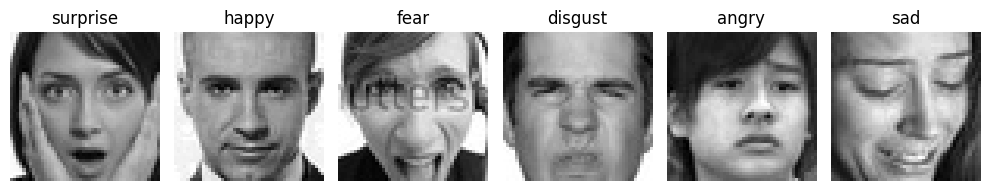

In [3]:
import random
def display_sample_images(directory, num_images=6):
    classes = os.listdir(directory)
    plt.figure(figsize=(10, 3))

    for i, class_name in enumerate(classes[:num_images]):
        class_dir = os.path.join(directory, class_name)
        image_name = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, image_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')  # Display in grayscale
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
display_sample_images(train_dir)

In [4]:
from PIL import Image
import imghdr

def find_unsupported_images(directory):
    unsupported = []
    valid_formats = {'jpeg', 'png', 'gif', 'bmp'}

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, image_name)
            try:
                kind = imghdr.what(img_path)
                if kind not in valid_formats:
                    unsupported.append(img_path)
            except Exception as e:
                unsupported.append(img_path)

    return unsupported

# Check both train and test directories
bad_train = find_unsupported_images(train_dir)
bad_test = find_unsupported_images(test_dir)
bad_val = find_unsupported_images(val_dir)
print(f"Train: {len(bad_train)} unsupported/corrupt images")
print(f"Test: {len(bad_test)} unsupported/corrupt images")
print(f'Validation: {len(bad_val)} unsupported/corrupt images')


Train: 49 unsupported/corrupt images
Test: 0 unsupported/corrupt images
Validation: 0 unsupported/corrupt images


In [5]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 7 classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
from pathlib import Path
def delete_corrupt_images(corrupt_images):
    for img_path in corrupt_images:
        try:
            img_file = Path(img_path)
            if img_file.exists():
                img_file.unlink()
                print(f"Deleted: {img_path}")
        except Exception as e:
            print(f"Failed to delete {img_path}: {e}")

# Run cleanup
bad_train = find_unsupported_images(train_dir)
bad_test = find_unsupported_images(test_dir)
bad_val = find_unsupported_images(val_dir)
print(f"Train: {len(bad_train)} bad images | Test: {len(bad_test)} bad images | Test: {len(bad_val)} bad images")

delete_corrupt_images(bad_train + bad_test + bad_val)

Train: 49 bad images | Test: 0 bad images | Test: 0 bad images
Deleted: /content/facial expression classification/train/surprise/21366.jpg
Deleted: /content/facial expression classification/train/surprise/9703.jpg
Deleted: /content/facial expression classification/train/surprise/33242.jpg
Deleted: /content/facial expression classification/train/surprise/18532.jpg
Deleted: /content/facial expression classification/train/surprise/19774.jpg
Deleted: /content/facial expression classification/train/surprise/32170.jpg
Deleted: /content/facial expression classification/train/surprise/20587.jpg
Deleted: /content/facial expression classification/train/happy/13823.jpg
Deleted: /content/facial expression classification/train/happy/3963.jpg
Deleted: /content/facial expression classification/train/happy/21206.jpg
Deleted: /content/facial expression classification/train/happy/7596.jpg
Deleted: /content/facial expression classification/train/happy/6112.jpg
Deleted: /content/facial expression classifi

Part A: Implementing Convolutional Neural Network from scratch.

In [7]:
def count_images(directory):
    counts = {}
    for cls in sorted(os.listdir(directory)):
        cls_dir = os.path.join(directory, cls)
        if os.path.isdir(cls_dir):
            counts[cls] = len(os.listdir(cls_dir))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)
print("Train class counts:", train_counts)
print("Validation class counts:", val_counts)
print("Test class counts:", test_counts)

Train class counts: {'angry': 3686, 'disgust': 329, 'fear': 3796, 'happy': 6857, 'neutral': 4675, 'sad': 4631, 'surprise': 2898}
Validation class counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}
Test class counts: {'angry': 300, 'disgust': 100, 'fear': 300, 'happy': 300, 'neutral': 300, 'sad': 300, 'surprise': 300}


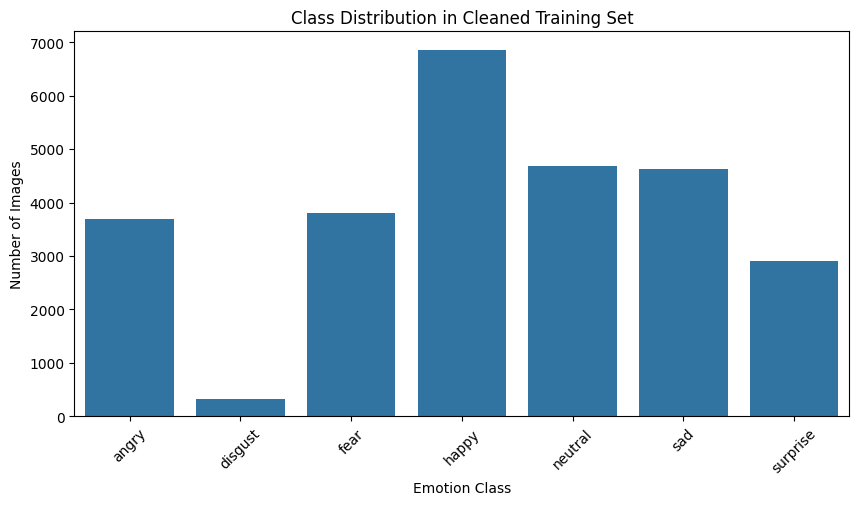

In [8]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Class Distribution in Cleaned Training Set')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

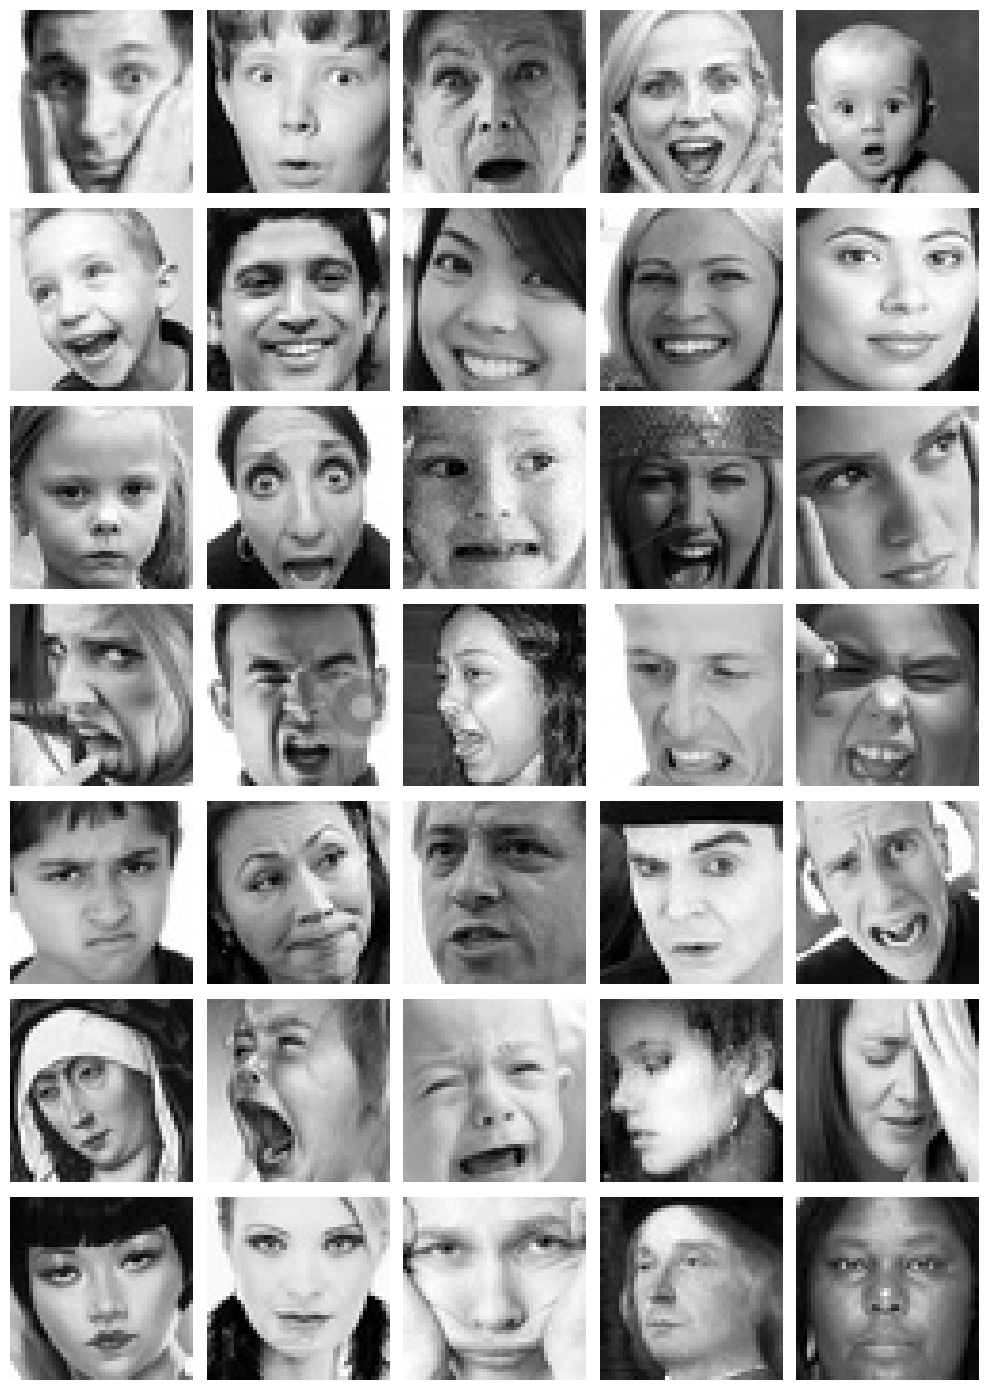

In [9]:
def show_images_per_class(directory, images_per_class=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(images_per_class * 2, len(classes) * 2))

    for row, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        image_names = random.sample(os.listdir(class_dir), min(images_per_class, len(os.listdir(class_dir))))

        for col, image_name in enumerate(image_names):
            img_path = os.path.join(class_dir, image_name)
            img = Image.open(img_path).convert('L')

            plt.subplot(len(classes), images_per_class, row * images_per_class + col + 1)
            plt.imshow(img, cmap='gray')
            if col == 0:
                plt.ylabel(class_name, fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images_per_class(train_dir)


In [10]:
from collections import Counter
def image_shapes_summary(directory):
    shapes = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, image_name)
            try:
                with Image.open(img_path) as img:
                    shapes.append(img.size)
            except:
                pass
    shape_counts = Counter(shapes)
    print("Image sizes and their frequencies:")
    for shape, count in shape_counts.items():
        print(f"{shape}: {count} images")

image_shapes_summary(train_dir)

Image sizes and their frequencies:
(48, 48): 26872 images


In [11]:
# 3. Define Data Generators (with augmentation only on train)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


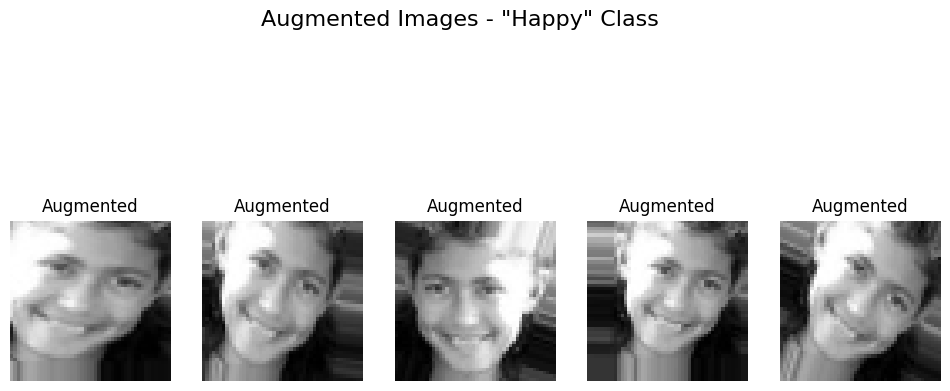

In [12]:
# 4. Visualize Augmented Images from any class (Example: 'happy')
example_class = 'happy'
example_dir = os.path.join(train_dir, example_class)
example_img_path = os.path.join(example_dir, os.listdir(example_dir)[0])

from tensorflow.keras.preprocessing import image

img = image.load_img(example_img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

aug_iter = train_datagen.flow(img_array, batch_size=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    batch = next(aug_iter)
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0].reshape(48, 48), cmap='gray')
    plt.title('Augmented')
    plt.axis('off')
plt.suptitle(f'Augmented Images - "{example_class.capitalize()}" Class', fontsize=16)
plt.show()

In [13]:
img_height, img_width = 128, 128
batch_size = 32

train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

class_names = train_ds_raw.class_names
NUM_CLASSES = len(class_names)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))

Found 26872 files belonging to 7 classes.
Found 1900 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [14]:
from tensorflow.keras import layers, models

# Define input shape matching your dataset
input_shape = (128, 128, 3)

# Build the baseline CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),

    layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,315,207 (12.65 MB)

 Trainable params: 3,315,207 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Train the model using train_ds and test_ds as validation
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.2710 - loss: 1.7559 - val_accuracy: 0.4048 - val_loss: 1.5383
Epoch 2/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.4256 - loss: 1.4687 - val_accuracy: 0.4598 - val_loss: 1.3813
Epoch 3/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.4950 - loss: 1.2941 - val_accuracy: 0.4914 - val_loss: 1.3298
Epoch 4/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.5610 - loss: 1.1498 - val_accuracy: 0.5035 - val_loss: 1.3409
Epoch 5/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.6310 - loss: 0.9880 - val_accuracy: 0.4999 - val_loss: 1.4652
Epoch 6/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.7020 - loss: 0.8147 - val_accuracy: 0.4945 - val_loss: 1.6946
Epoch 7/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.7721 - loss: 0.6356 - val_accuracy: 0.4935 - val_loss: 1.9169
Epoch 8/15
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8270 - loss: 0.4802 - 

3.1.3 Design, Train, and Evaluate Deeper Architecture with Regularization

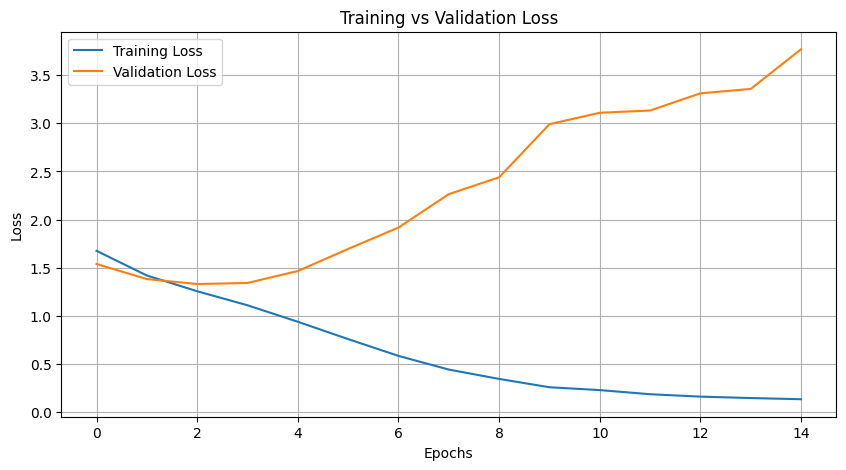

In [17]:
# Plotting training vs validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 3. Final model evaluation on test_ds
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3502 - loss: 5.2039
Test Accuracy: 44.37%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

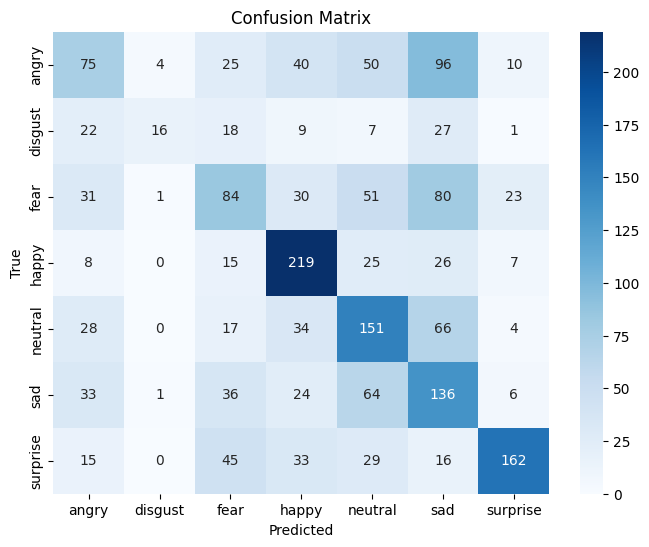

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


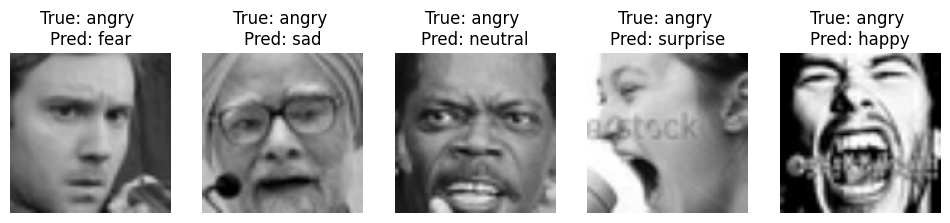

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate and get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Sample Inference and Visualization
def show_inference_sample(dataset):
    import matplotlib.pyplot as plt
    class_labels = class_names
    images, labels = next(iter(dataset))
    preds = model.predict(images)
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.title(f"True: {class_labels[np.argmax(labels[i])]} \nPred: {class_labels[np.argmax(preds[i])]}")
        plt.axis('off')
    plt.show()

show_inference_sample(test_ds)


In [20]:
from tensorflow.keras import layers, models, regularizers

# Build a deeper CNN model with regularization
deeper_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
deeper_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Display the deeper model summary
deeper_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,278,151 (20.13 MB)

 Trainable params: 5,275,399 (20.12 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Train the deeper model
history_deeper_adam = deeper_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=21,  # Use more epochs, but early stopping will prevent overfitting
    callbacks=[early_stop]
)


Epoch 1/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.2063 - loss: 4.2646 - val_accuracy: 0.2770 - val_loss: 3.1228
Epoch 2/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.3422 - loss: 2.9164 - val_accuracy: 0.4125 - val_loss: 2.5962
Epoch 3/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.4248 - loss: 2.5113 - val_accuracy: 0.3704 - val_loss: 2.6171
Epoch 4/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.4710 - loss: 2.2766 - val_accuracy: 0.5047 - val_loss: 2.2054
Epoch 5/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4860 - loss: 2.2293 - val_accuracy: 0.4963 - val_loss: 2.2542
Epoch 6/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.4937 - loss: 2.2583 - val_accuracy: 0.4809 - val_loss: 2.2924
Epoch 7/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4958 - loss: 2.2152 - val_accuracy: 0.5055 - val_loss: 2.2382
Epoch 8/21
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5018 - loss: 2.2233 - 

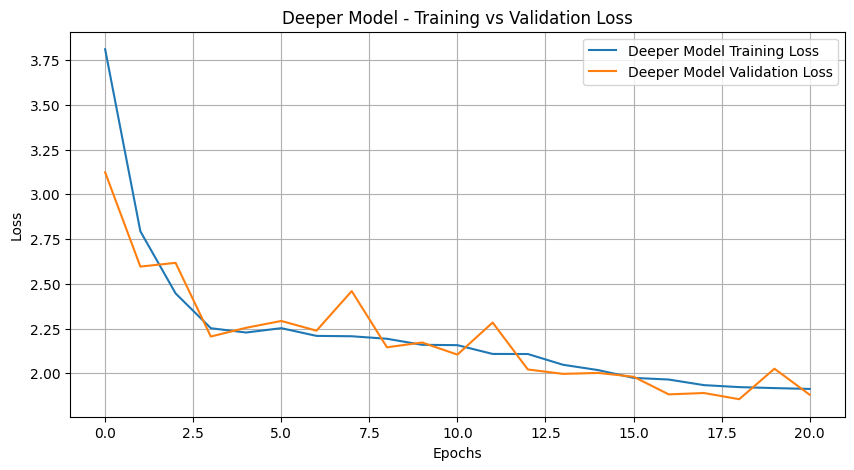

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(history_deeper_adam.history['loss'], label='Deeper Model Training Loss')
plt.plot(history_deeper_adam.history['val_loss'], label='Deeper Model Validation Loss')
plt.title('Deeper Model - Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import time

start_time = time.time()
# train the model...
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


Training time: 0.00 seconds


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3731 - loss: 2.2232
Deeper Model Test Accuracy: 47.16%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       angry       0.48      0.36      0.41       300
     disgust       0.00      0.00      0.00       100
        fear       0.44      0.14      0.21       300
       happy       0.52      0.84      0.64       300
     neutral       0.50      0.45      0.47       300
         sad       0.31      0.66      0.43       300
    surprise       0.80      0.55      0.65       300

    accuracy                           0.47      1900
   macro avg       0.44      0.43      0.40      1900
weighted avg       0.48      0.47      0.44      1900



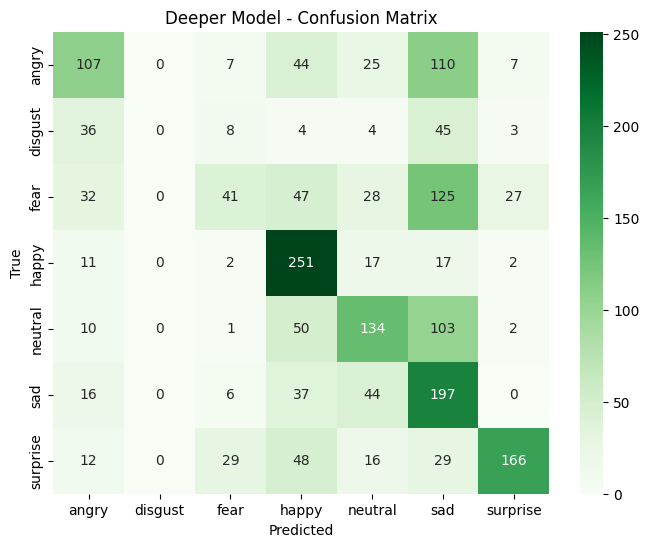

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


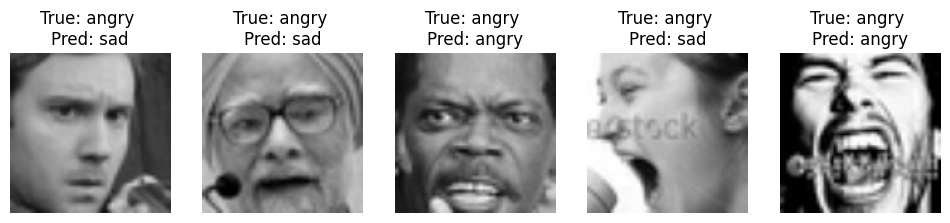

In [24]:
# Evaluate on test_ds
test_loss_deeper, test_accuracy_deeper = deeper_model.evaluate(test_ds)
print(f"Deeper Model Test Accuracy: {test_accuracy_deeper * 100:.2f}%")

# Predictions and metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = deeper_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Deeper Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Inference visualization
def show_inference_sample_deeper(dataset):
    images, labels = next(iter(dataset))
    preds = deeper_model.predict(images)
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"True: {class_names[np.argmax(labels[i])]} \nPred: {class_names[np.argmax(preds[i])]}")
        plt.axis('off')
    plt.show()

show_inference_sample_deeper(test_ds)


In [25]:
# Evaluate baseline model (assuming you already trained baseline_model earlier)
test_loss_baseline, test_accuracy_baseline = model.evaluate(test_ds)
print(f"Baseline Model Test Accuracy: {test_accuracy_baseline * 100:.2f}%")

# Already evaluated deeper model as:
test_loss_deeper, test_accuracy_deeper = deeper_model.evaluate(test_ds)
print(f"Deeper Model Test Accuracy: {test_accuracy_deeper * 100:.2f}%")


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3502 - loss: 5.2039
Baseline Model Test Accuracy: 44.37%
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3731 - loss: 2.2232
Deeper Model Test Accuracy: 47.16%


In [26]:
deeper_model_sgd = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Build deeper model again with SGD optimizer
deeper_model_sgd.compile(optimizer='sgd',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Display the deeper model summary
deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 15,828,951 (60.38 MB)

 Trainable params: 5,275,399 (20.12 MB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 10,550,800 (40.25 MB)

In [28]:
# Train with SGD
history_sgd = deeper_model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.1886 - loss: 4.2563 - val_accuracy: 0.2740 - val_loss: 3.5396
Epoch 2/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.2747 - loss: 3.5382 - val_accuracy: 0.3119 - val_loss: 3.4146
Epoch 3/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.3155 - loss: 3.4013 - val_accuracy: 0.3571 - val_loss: 3.3288
Epoch 4/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3403 - loss: 3.2946 - val_accuracy: 0.3534 - val_loss: 3.2973
Epoch 5/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.3647 - loss: 3.2026 - val_accuracy: 0.2896 - val_loss: 3.3038
Epoch 6/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.3786 - loss: 3.1249 - val_accuracy: 0.4060 - val_loss: 3.0525
Epoch 7/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.3929 - loss: 3.0390 - val_accuracy: 0.4324 - val_loss: 2.9177
Epoch 8/20
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4080 - loss: 2.9581 - 

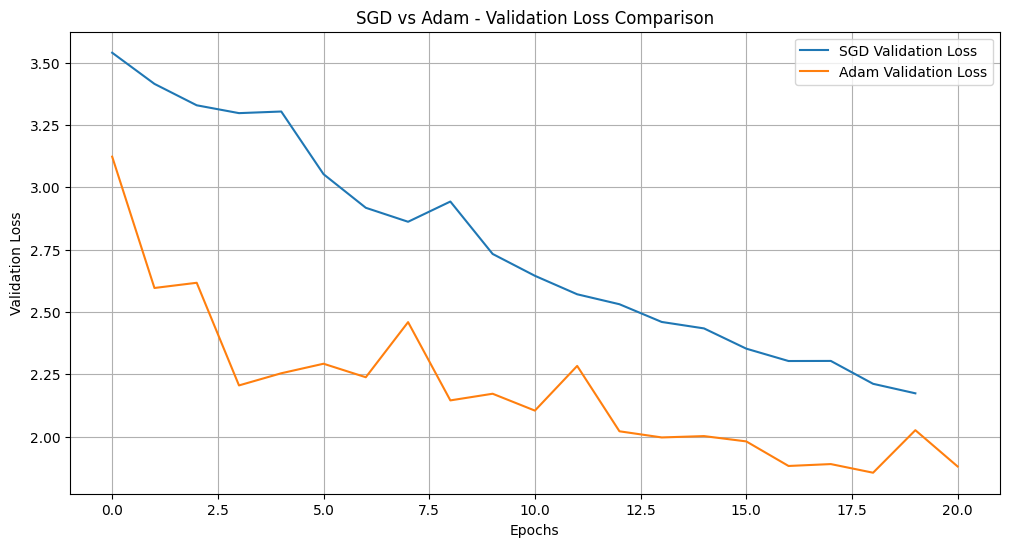

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(history_sgd.history['val_loss'], label='SGD Validation Loss')
plt.plot(history_deeper_adam.history['val_loss'], label='Adam Validation Loss')
plt.title('SGD vs Adam - Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define input size as per VGG16 requirements
IMG_SIZE = 224

# Update dataset for VGG16 (224x224 input size, 3 channels)
train_ds_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

val_ds_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False,
    label_mode='categorical'
)

test_ds_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False,
    label_mode='categorical'
)
class_names = train_ds_vgg.class_names
NUM_CLASSES = len(class_names)

Found 26872 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.
Found 1900 files belonging to 7 classes.


In [31]:
normalization_layer_vgg = tf.keras.layers.Rescaling(1./255)
train_ds_vgg = train_ds_vgg.map(lambda x, y: (normalization_layer_vgg(x), y))
val_ds_vgg = val_ds_vgg.map(lambda x, y: (normalization_layer_vgg(x), y))
test_ds_vgg = test_ds_vgg.map(lambda x, y: (normalization_layer_vgg(x), y))

In [32]:
# Load pre-trained VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [33]:
# Freeze the base model for feature extraction
base_model.trainable = False

In [34]:
transfer_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [35]:
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train only the top layers first (feature extraction phase)
history_transfer = transfer_model.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 199s 221ms/step - accuracy: 0.2624 - loss: 2.0086 - val_accuracy: 0.3930 - val_loss: 1.5403
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 167s 198ms/step - accuracy: 0.3121 - loss: 1.6494 - val_accuracy: 0.4014 - val_loss: 1.5503
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 167s 198ms/step - accuracy: 0.3200 - loss: 1.6293 - val_accuracy: 0.4275 - val_loss: 1.5329
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 167s 198ms/step - accuracy: 0.3403 - loss: 1.5875 - val_accuracy: 0.4335 - val_loss: 1.4649
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 167s 198ms/step - accuracy: 0.3439 - loss: 1.5760 - val_accuracy: 0.4169 - val_loss: 1.4923
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 202s 199ms/step - accuracy: 0.3473 - loss: 1.5665 - val_accuracy: 0.4223 - val_loss: 1.4770
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 173s 206ms/step - accuracy: 0.3551 - loss: 1.5468 - val_accuracy: 0.4308 - val_loss: 1.4444
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 167s 199ms/step - accuracy: 0.3557 -

In [ ]:
# Unfreeze last few convolutional layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Unfreeze last 4 layers only
    layer.trainable = False

# Compile with lower learning rate for fine-tuning
transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Fine-tune the entire model
history_finetune = transfer_model.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 225s 247ms/step - accuracy: 0.4500 - loss: 1.3636 - val_accuracy: 0.5047 - val_loss: 1.3228
Epoch 2/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 249s 242ms/step - accuracy: 0.4673 - loss: 1.3084 - val_accuracy: 0.5123 - val_loss: 1.3222
Epoch 3/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 209s 248ms/step - accuracy: 0.4836 - loss: 1.2798 - val_accuracy: 0.5236 - val_loss: 1.2965
Epoch 4/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 257s 242ms/step - accuracy: 0.4917 - loss: 1.2532 - val_accuracy: 0.5297 - val_loss: 1.3011
Epoch 5/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 204s 242ms/step - accuracy: 0.4972 - loss: 1.2307 - val_accuracy: 0.5328 - val_loss: 1.2902
Epoch 6/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 204s 243ms/step - accuracy: 0.5050 - loss: 1.2089 - val_accuracy: 0.5447 - val_loss: 1.2734
Epoch 7/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 209s 248ms/step - accuracy: 0.5167 - loss: 1.1916 - val_accuracy: 0.5414 - val_loss: 1.2774
Epoch 8/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 204s 242ms/step - accuracy: 0.5249 -

60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.3159 - loss: 1.8669
Transfer Learning Model Test Accuracy: 15.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       angry       0.16      0.52      0.24       301
     disgust       0.00      0.00      0.00       100
        fear       0.16      0.43      0.24       304
       happy       0.00      0.00      0.00       300
     neutral       0.09      0.00      0.01       300
         sad       0.13      0.02      0.04       300
    surprise       0.31      0.01      0.03       300

    accuracy                           0.16      1905
   macro avg       0.12      0.14      0.08      1905
weighted avg       0.13      0.16      0.09      1905



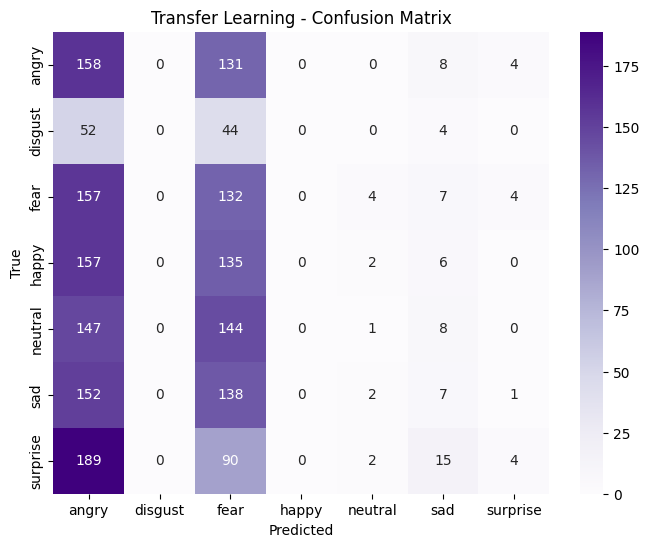

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


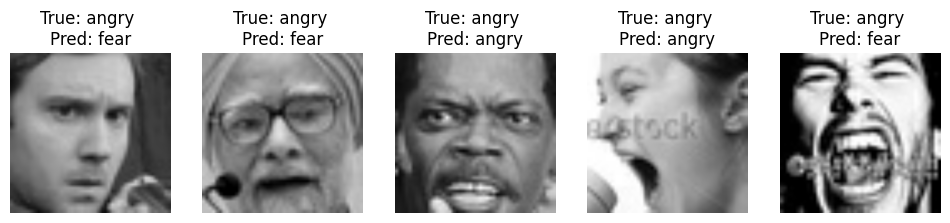

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
# Evaluate on test set
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_ds_vgg)
print(f"Transfer Learning Model Test Accuracy: {test_accuracy_transfer * 100:.2f}%")

# Predictions and classification report
y_true = []
y_pred = []

for images, labels in test_ds_vgg:
    preds = transfer_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Transfer Learning - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Inference visualization
def show_inference_sample_transfer(dataset):
    images, labels = next(iter(dataset))
    preds = transfer_model.predict(images)
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"True: {class_names[np.argmax(labels[i])]} \nPred: {class_names[np.argmax(preds[i])]}")
        plt.axis('off')
    plt.show()

show_inference_sample_transfer(test_ds_vgg)
